In [87]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

df= pd.read_csv('../datasets/normalized_sample_emissions_for_anomaly_detection.csv')
df.head()

,Identifiant de l'élément,Nom base français,normalized_emissions,modifed_emissions,true_anomaly
0,34052,"""""""\tSalade César au poulet (salade verte""""""",0.044497,0.044497,0
1,40963,"""""""Barre céréalière """"""""équilibre"""""""" aux frui...",0.038913,0.038913,0
2,40964,"""""""Barre céréalière """"""""équilibre"""""""" chocolat...",0.096827,0.968267,1
3,39789,"""""""Bière """"""""coeur de marché"""""""" (4-5° alcool)""""""",0.017534,0.017534,0
4,39790,"""""""Bière """"""""de spécialités"""""""" ou d'abbaye""""""",0.017534,0.017534,0


In [88]:
min_val = df['modifed_emissions'].min()
max_val = df['modifed_emissions'].max()
print(f"Min: {min_val}, Max: {max_val}")
X = df[['modifed_emissions']].values

Min: 0.0, Max: 2.0


In [89]:
def model_summary(model,title):
    model.fit(X)

    predictions = model.predict(X)

    true_labels = df['true_anomaly'].values

    df['predicted_anomaly'] = predictions


    print("\n Classification Report:")
    print(classification_report(true_labels, predictions))

    #Confustion Matrix
    cm = confusion_matrix(true_labels, predictions)
    labels = ['Normal', 'Anomaly']

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    #
    plt.figure(figsize=(12, 5))
    sns.scatterplot(
        x=range(len(df)),
        y=df['modifed_emissions'],
        hue=df['predicted_anomaly'],
        palette={0: 'blue', 1: 'red'},
        legend='full'
    )
    plt.title(f"{title}: Anomaly Detection Results")
    plt.xlabel("Data Index")
    plt.ylabel("Modified Emissions")
    plt.show()

    



# ISOLATION FORREST

In [90]:
from pyod.models.iforest import IForest

model = IForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.02,  
    max_features=1.0,
    random_state=19
)



 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4219
           1       0.81      0.77      0.79        83

    accuracy                           0.99      4302
   macro avg       0.90      0.88      0.89      4302
weighted avg       0.99      0.99      0.99      4302



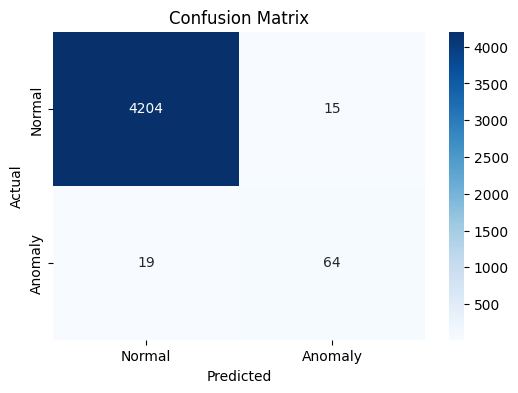

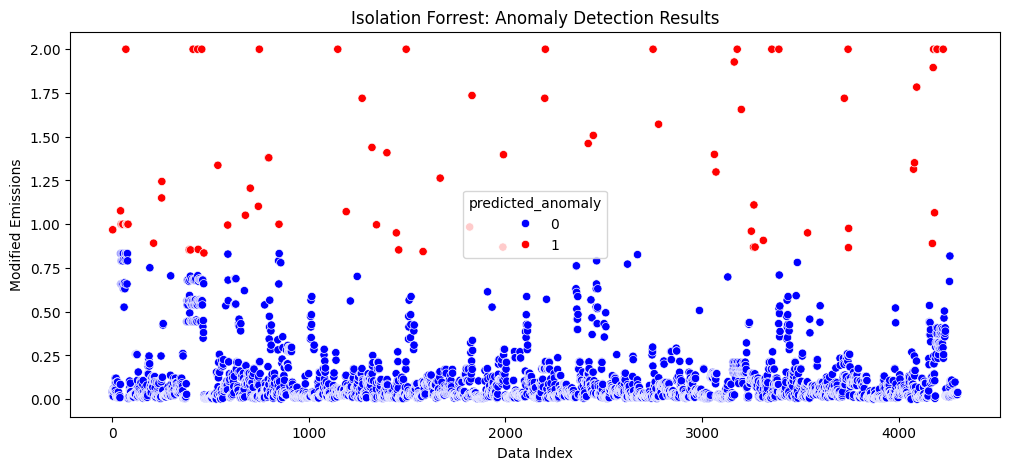

In [91]:
model_summary(model=model,title="Isolation Forrest")

# One-Class SVM

In [117]:
from pyod.models.ocsvm import OCSVM
model = OCSVM(
    kernel='rbf',
    nu=0.07,
    contamination=0.02
)



 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4219
           1       0.81      0.77      0.79        83

    accuracy                           0.99      4302
   macro avg       0.90      0.88      0.89      4302
weighted avg       0.99      0.99      0.99      4302



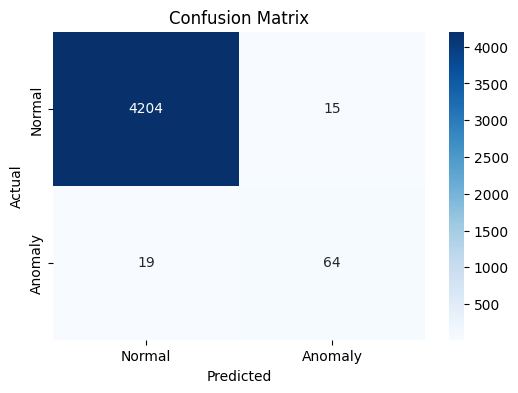

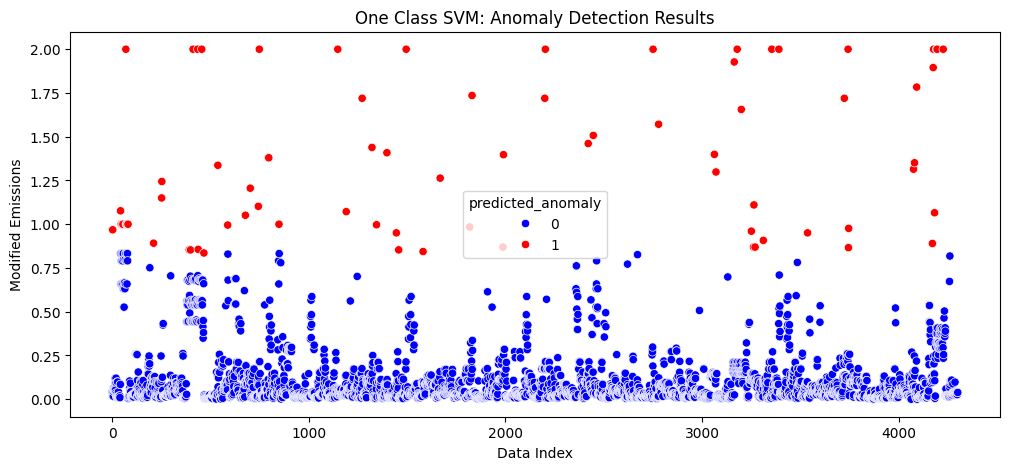

In [118]:
model_summary(model=model,title="One Class SVM")

### pyOD is more flexible than isolation forrest because we compute the scores with decision_function() to create custom threshold but this means it is more sensitive and needs extra tuning.
 pyOD offers  a AE-1SVM (auto encoder) for complex data and when we need our model to understand context

# Local Outlier Factor


In [123]:
from pyod.models.lof import LOF
model = LOF(n_neighbors=200,
            algorithm='auto',
            metric='manhattan',
            contamination=0.03
            )


 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4219
           1       0.52      0.80      0.63        83

    accuracy                           0.98      4302
   macro avg       0.76      0.89      0.81      4302
weighted avg       0.99      0.98      0.98      4302



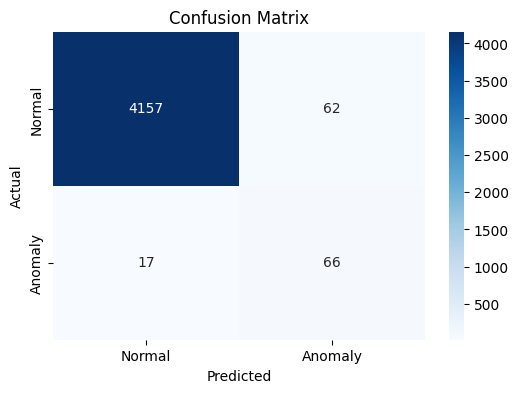

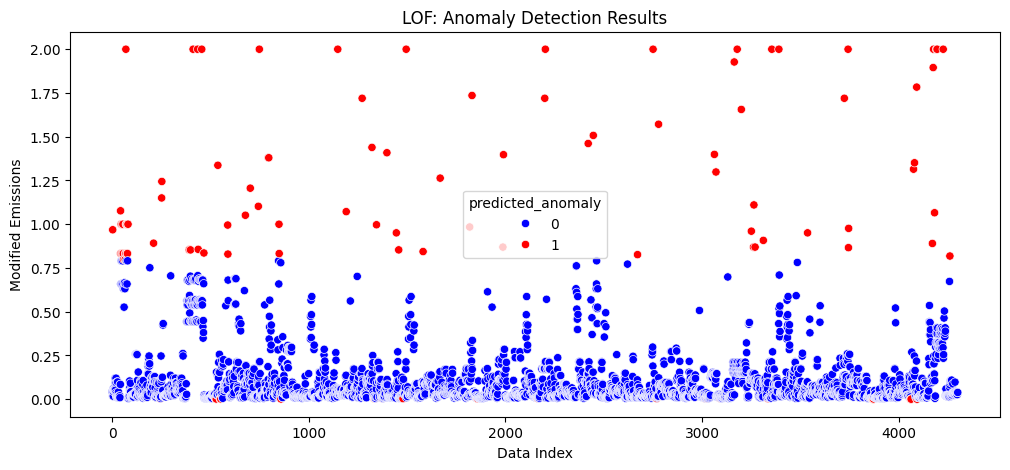

In [124]:
model_summary(model,'LOF')

### LOF underpreformed compared to the other models due to its nature. LOF is designed for complex, local density patterns( varying subgroups,clusters ...) Our data is just emission values normalized (between 0 and 1). so relying only on distance will yield bad results which we got because the model is false flagging a lot of anomalies 